# Compute climate projections from different GCM models and RCP

## Introduction

Nokebook for the workflow **Snakefile_climate_projections**: derives future climate statistics (expected temperature and precipitation change) for different RCPs and GCMs (from CMIP dataset).

In [1]:
# Import some python libraries we will need to run this notebook
import os
from IPython import display

In [2]:
# A helper function
from subprocess import Popen, PIPE, STDOUT

from IPython.core.magic import register_line_magic


@register_line_magic
def runrealcmd(command):
    with Popen(
        command, stdout=PIPE, shell=True, stderr=STDOUT, bufsize=1, close_fds=True
    ) as process:
        for line in iter(process.stdout.readline, b""):
            print(line.rstrip().decode("utf-8"))

## Choosing your climate datasets and scenarios

First thing is to prepare all the options for your project, this is done using the configuration or settings file below

In [3]:
# Add here the path where you have installed the blueearth-cst tool
cst_path = r'C:\Users\boisgont\D\Repos\CST\blueearth_cst'
os.chdir(cst_path)

To chose where the river or basin you want to work with, you will need to supply the location of your river.

The location can either be:
- for a basin to the sea, any point in the basin [x, y]
- for a subbasin (tributary or part of a basin) the location of the subbasin outlet [xout, yout]
- a bounding box [xmin, ymin, xmax, ymax]
- a geometry file of your region of interest (eg, myregion.shp)

The coordinates should be in EPSG 4326.
For points, you can use Google Maps to locate your coordinates.
For bounding box or point cooridnates, you can also copy-paste locations from this website: http://bboxfinder.com/

In [4]:
%%writefile ./config/my-project-settings.yml

###########################################################################################
#################################### General setting ######################################

# Path to where the wflow model will be stored (include the project name)
project_name: myModel
project_dir: examples/myModel

# Path to the data catalog to use (can be different for Linux/Windows/data stored on P drive or other)
data_sources: config/deltares_data.yml
# Path to the data catalog to use (can be different for Linux/Windows/data stored on P drive or other)
data_sources_climate: config/deltares_data_climate_projections.yml

# Time horizon of the historical period
starttime: "2000-01-01T00:00:00"
endtime: "2020-12-31T00:00:00"

###########################################################################################
#################################### Model building #######################################

# hydromt "region" for building the model, coordinates are in EPSG 4326
# for more info on how to fill this, you can see the hydromt documentation: 
# https://deltares.github.io/hydromt/latest/user_guide/cli.html#region-options
# For wflow please use either 'basin' or 'subbasin' keywords
model_region: "{'subbasin': [108.152711, 15.571764], 'strord': 3}"
# Grid resolution of the model in degrees
model_resolution: 0.0062475

# If available, please here put the path to the available observation stations locations files
# csv file containing three columns: station_ID, x, y
output_locations: None # If set to None, will default to the wflow outlets
# Path to the file with observed discharge timeseries per station 
observations_timeseries: None
    
###########################################################################################
################################## Climate projections ####################################
# climate models and scenarios
clim_project: cmip5
models: ['MIROC5']
scenarios: [rcp45, rcp85]
members: [r1i1p1]

variables: [precip, temp, temp_min, temp_max]

# time horizons of the climate projections
start_month_hyd_year: Jan
historical: 1960, 2000
future_horizons: 
  near: 2020, 2060
#  far: 2060, 2100

Overwriting ./config/my-project-settings.yml


## Running the model building workflow

The first line is to create an image of our workflow with snakemake to verify that all our settings are well taken into account.

In [5]:
! snakemake -s Snakefile_climate_projections --configfile config/my-project-settings.yml  --dag | dot -Tpng > dag_projections.png

Building DAG of jobs...


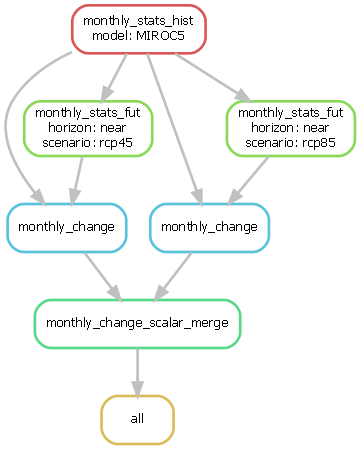

In [6]:
display.Image("./dag_projections.png")

Now we will unlock your directory in order to save the future results of the workflow. This step is most of the time not necessary.

In [7]:
! snakemake --unlock -s Snakefile_climate_projections --configfile config/my-project-settings.yml

Unlocking working directory.


And finally let's run our worflow:

In [8]:
%runrealcmd snakemake all -c 1 -s Snakefile_climate_projections --configfile config/my-project-settings.yml

C:\Users\boisgont\Miniconda3\envs\blueearth-cst\lib\subprocess.py:956: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)


Building DAG of jobs...
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
Job stats:
job                            count    min threads    max threads
---------------------------  -------  -------------  -------------
all                                1              1              1
monthly_change                     2              1              1
monthly_change_scalar_merge        1              1              1
monthly_stats_fut                  2              1              1
monthly_stats_hist                 1              1              1
total                              7              1              1

Select jobs to execute...

[Wed Apr 13 14:21:23 2022]
rule monthly_stats_hist:
    input: examples/myModel/hydrology_model/staticgeoms/region.geojson
    output: examples/myModel/climate_projections/cmip5/historical_stats_time_MIROC5.nc
    jobid: 3
    wildcards: model=MIROC5
    resources: tmpdir=C:\Users\boisgont\AppData

## Results

First check that snake did run everything.

In [ ]:
! snakemake -s Snakefile_climate_projections --configfile config/my-project-settings.yml  --dag | dot -Tpng > dag_projections.png

In [ ]:
display.Image("./dag_projections.png")

Let's see which files where created in our output folder.

In [ ]:
root = "examples/myModel"
for path, _, files in os.walk(root):
    print(path)
    for name in files:
        if name.endswith(".xml"):
            continue
        print(f" - {name}")

In [9]:
import pandas as pd
df = pd.read_csv('examples/myModel/climate_projections/cmip5/annual_change_scalar_stats_summary_mean.csv')
df

,clim_project,model,scenario,horizon,member,stats,spatial_ref,precip,temp_min,temp
0,cmip5,MIROC5,rcp45,near,r1i1p1,mean,1,3.260877,1.39607,1.391449
1,cmip5,MIROC5,rcp85,near,r1i1p1,mean,1,2.025112,1.45400,1.399809
